# 1. Выбор начальных условий

**a. Набор данных для классификации: Breast Cancer Dataset**

- Практическая задача: Автоматизация диагностики рака молочной железы на основе характеристик опухоли (полученных, например, с помощью тонкоигольной аспирации). Помогает врачу в принятии решения, снижая нагрузку и субъективность.
- Обоснование выбора: Данные чистые, хорошо структурированы, имеют медицинское значение. Задача бинарной классификации (M - злокачественная / B - доброкачественная) идеально подходит для KNN, так как предполагает нахождение "похожих" случаев в истории.

**b. Набор данных для регрессии: Vehicle Dataset**

- Практическая задача: Предсказание рыночной стоимости подержанного автомобиля для онлайн-площадок, страховых компаний или личного использования.
- Обоснование выбора: Интуитивно понятные признаки (год, пробег, тип топлива и т.д.). Цена (selling_price) - непрерывная целевая переменная. KNN для регрессии будет искать цены на "похожие" по характеристикам автомобили.

**c. Выбор метрик качества**

*Классификация (Breast Cancer):*

- Accuracy (Точность): Базовая метрика. Важна, но может вводить в заблуждение при несбалансированных классах (здесь баланс ~63% доброкачественных, 37% злокачественных - допустимый).
- Precision (Точность) для класса M: Доля реально больных среди тех, кого модель назвала больными. Критически важна. Ложноположительный диагноз (сказать "рак", когда его нет) ведет к ненужному стрессу и дополнительным обследованиям.
- Recall (Полнота) для класса M: Доля правильно выявленных больных среди всех реально больных. Крайне важна. Ложноотрицательный диагноз (пропустить рак) опасен для жизни.
- F1-score (для класса M): Гармоническое среднее Precision и Recall. Дает сбалансированную оценку.
- ROC-AUC: Оценивает способность модели ранжировать объекты (разделять два класса). Хорошо работает на сбалансированных данных.

**Итог: Основной фокус на Precision и Recall для класса M (злокачественная опухоль).**

*Регрессия (Vehicle):*

- MAE (Mean Absolute Error, Средняя абсолютная ошибка): Показывает среднее отклонение предсказания от реальной цены в рублях/долларах. Легко интерпретировать.
- RMSE (Root Mean Squared Error, Корень из средней квадратичной ошибки): Более чувствительна к большим выбросам в цене. Показывает "стандартную" ошибку предсказания.
- R² (Коэффициент детерминации): Показывает, какую долю дисперсии целевой переменной объясняет модель. Хороша для сравнения моделей на разных данных.

**Итог: Используем все три, так как они дополняют друг друга. Для бизнеса наиболее важен MAE ("в среднем ошибаемся на X рублей").**

# 2. Создание бейзлайна и оценка качества

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных
# Классификация
df_cancer = pd.read_csv('/content/breast-cancer.csv.xls')
# Регрессия
df_cars = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv.xls')

In [ ]:
# Предварительный просмотр
print("Классификация: Breast Cancer Dataset")
df_cancer.head()
print(f"\nРазмер: {df_cancer.shape}")
print(f"\nЦелевая переменная diagnosis:\n{df_cancer['diagnosis'].value_counts()}")
df_cancer.describe()

Классификация: Breast Cancer Dataset

Размер: (569, 32)

Целевая переменная diagnosis:
diagnosis
B    357
M    212
Name: count, dtype: int64


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
print("Регрессия: Vehicle Dataset")
df_cars.head()
print(f"\nРазмер: {df_cars.shape}")
print(f"\nЦелевая переменная selling_price:")
df_cars['selling_price'].describe()

Регрессия: Vehicle Dataset
              year  selling_price      km_driven
count  4340.000000   4.340000e+03    4340.000000
mean   2013.090783   5.041273e+05   66215.777419
std       4.215344   5.785487e+05   46644.102194
min    1992.000000   2.000000e+04       1.000000
25%    2011.000000   2.087498e+05   35000.000000
50%    2014.000000   3.500000e+05   60000.000000
75%    2016.000000   6.000000e+05   90000.000000
max    2020.000000   8.900000e+06  806599.000000

Размер: (4340, 8)

Целевая переменная selling_price:


,selling_price
count,4.340000e+03
mean,5.041273e+05
std,5.785487e+05
min,2.000000e+04
25%,2.087498e+05
50%,3.500000e+05
75%,6.000000e+05
max,8.900000e+06


In [ ]:
df_cars.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


Для начала подготовим датасеты к обучению. Кодируем целевую переменную для классификации: M -> 1, B -> 0.

In [ ]:
# Сначала обучим и оценим бейзлайн для классификации
# Удалим ненужный столбец id
df_cancer_clean = df_cancer.drop('id', axis=1)
le = LabelEncoder()
df_cancer_clean['diagnosis'] = le.fit_transform(df_cancer_clean['diagnosis']) # 1 - Malignant, 0 - Benign

# Разделим на признаки и таргет
X_clf = df_cancer_clean.drop('diagnosis', axis=1)
y_clf = df_cancer_clean['diagnosis']
# Разделение на train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

In [ ]:
# Создаем и обучаем KNN (k=5 по умолчанию)
knn_clf_baseline = KNeighborsClassifier()
knn_clf_baseline.fit(X_train_clf, y_train_clf)
# Прогноз
y_pred_clf_baseline = knn_clf_baseline.predict(X_test_clf)
y_pred_proba_baseline = knn_clf_baseline.predict_proba(X_test_clf)[:, 1]

In [ ]:
# Оценка качества
print("=== КЛАССИФИКАЦИЯ (Базовый KNN) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_baseline):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_baseline):.3f}")

print(classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Benign', 'Malignant']))

=== КЛАССИФИКАЦИЯ (Базовый KNN) ===
Accuracy: 0.912
Precision (M): 0.971
Recall (M): 0.786
F1-score (M): 0.868
ROC-AUC: 0.955
              precision    recall  f1-score   support

      Benign       0.89      0.99      0.93        72
   Malignant       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



In [ ]:
# Теперь обучим регрессию
# Выберем признаки и таргет
# Для простоты базовой модели возьмем числовые признаки и закодируем категориальные простым LabelEncoder
df_cars_clean = df_cars.copy()
# Кодируем категориальные признаки
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    le_temp = LabelEncoder()
    df_cars_clean[col] = le_temp.fit_transform(df_cars_clean[col])
# Также преобразуем 'name' в категориальный код
df_cars_clean['name'] = LabelEncoder().fit_transform(df_cars_clean['name'])

X_reg = df_cars_clean.drop('selling_price', axis=1)
y_reg = df_cars_clean['selling_price']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [ ]:
# Создаем и обучаем KNN для регрессии (k=5 по умолчанию)
knn_reg_baseline = KNeighborsRegressor()
knn_reg_baseline.fit(X_train_reg, y_train_reg)
y_pred_reg_baseline = knn_reg_baseline.predict(X_test_reg)

In [ ]:
# Оценка качества
print("=== РЕГРЕССИЯ (Базовый KNN) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_reg_baseline):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_baseline)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_reg_baseline):.3f}")

=== РЕГРЕССИЯ (Базовый KNN) ===
MAE: 240296.07
RMSE: 472486.49
R²: 0.268


Мы получили базовые результаты. Они невысокие, особенно для регрессии, из-за отсутствия масштабирования признаков и обработки выбросов. Метрики для классификации приемлемые, но есть куда улучшать.

# 3. Улучшение бейзлайна

Формулировка гипотез:

- Масштабирование признаков критично для KNN, т.к. алгоритм использует расстояния. Без него признаки с большим разбросом (например, area_worst в раке, selling_price в авто) будут доминировать.
- Подбор гиперпараметров (n_neighbors, метрика расстояния, веса) значительно влияет на качество. n_neighbors=5 может быть неоптимальным.
- Удаление сильно коррелирующих признаков (для датасета с раком) может ускорить обучение и улучшить обобщающую способность.

Инженерия признаков для автомобилей:

- Создание car_age (текущий год - year) вместо year.
- Обработка выбросов в km_driven и selling_price.
- Более корректное кодирование категориальных признаков (One-Hot Encoding).


Балансировка классов (если потребуется) для классификации. Но в нашем случае дисбаланс не критичен, они не настолько сильно отличаются по количеству.



Корреляция признаков:


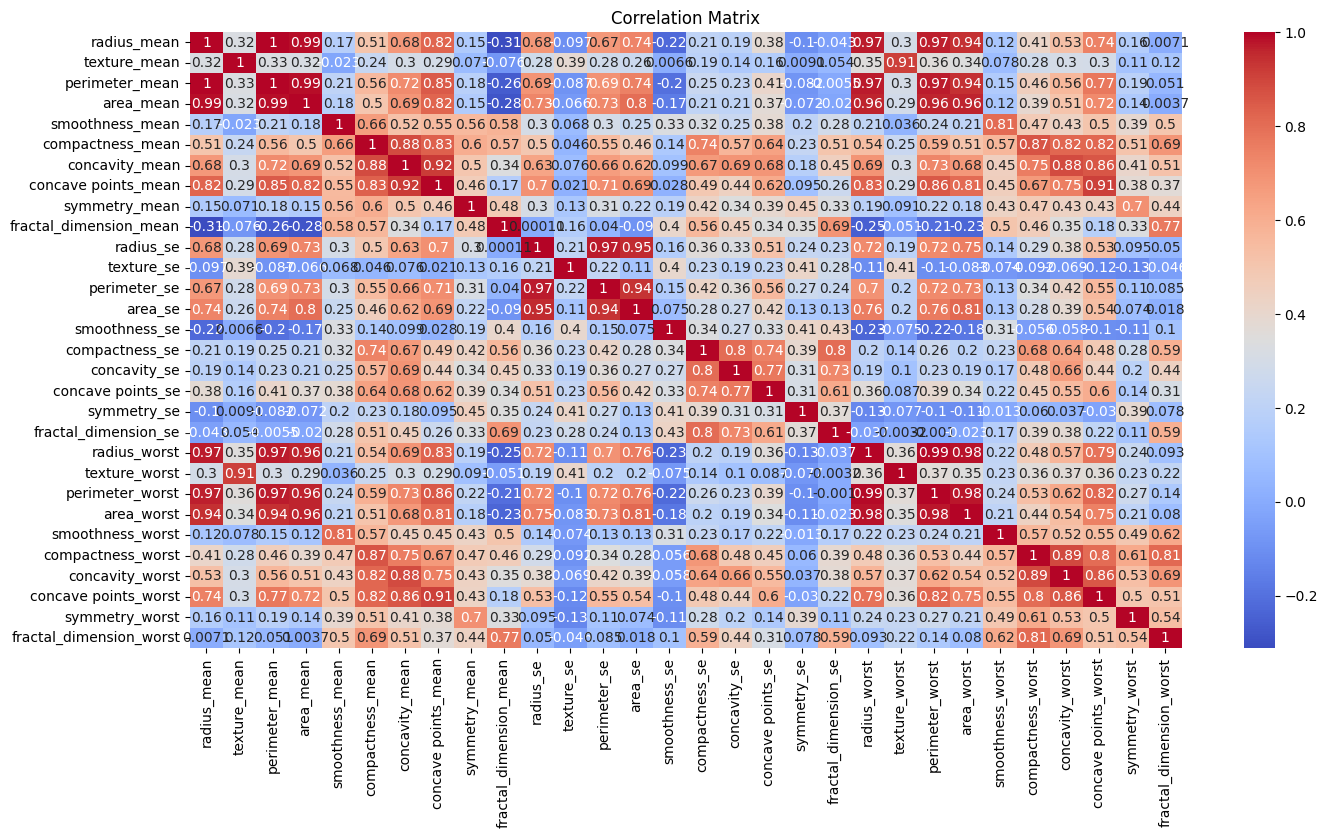

In [ ]:
print("\nКорреляция признаков:")
plt.figure(figsize=(16, 8))
numeric_df = X_clf.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix ')
plt.show()

Итак, видим, что датасет довольно подробный, зависимости между признаками очевидны и логичны. Попробуем удалить наиболее коррелируюшие признаки, чтобы улучшить результаты модели.


Корреляция признаков:


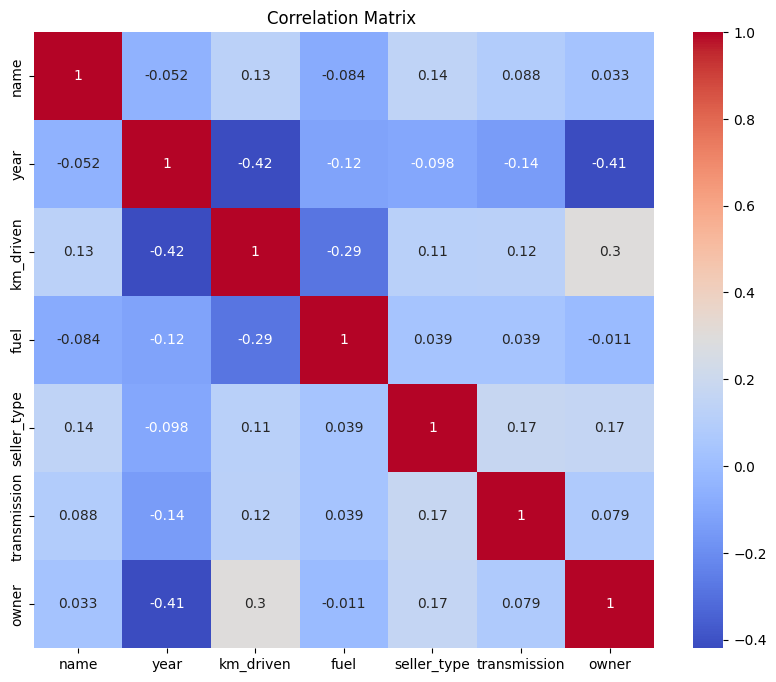

In [ ]:
print("\nКорреляция признаков:")
plt.figure(figsize=(10, 8))
numeric_df = X_reg.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix ')
plt.show()

In [ ]:
# УЛУЧШЕННЫЙ ПАЙПЛАЙН: КЛАССИФИКАЦИЯ
# Удаляем коррелирующие признаки (пример)
corr_matrix = X_train_clf.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] # Порог корреляции
print(f"Признаки для удаления из-за высокой корреляции: {to_drop}")
X_train_clf_imp = X_train_clf.drop(to_drop, axis=1)
X_test_clf_imp = X_test_clf.drop(to_drop, axis=1)

Признаки для удаления из-за высокой корреляции: ['perimeter_mean', 'area_mean', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']


In [ ]:
# Создаем пайплайн: масштабирование -> подбор гиперпараметров
pipe_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Параметры для GridSearchCV
param_grid_clf = {
    'knn__n_neighbors': list(range(3, 31, 2)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_clf = GridSearchCV(pipe_clf, param_grid_clf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_clf.fit(X_train_clf_imp, y_train_clf)

print(f"Лучшие параметры (классификация): {grid_clf.best_params_}")
print(f"Лучший score на кросс-валидации (F1): {grid_clf.best_score_:.3f}")

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Лучшие параметры (классификация): {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Лучший score на кросс-валидации (F1): 0.954


In [ ]:
# Оценка на тесте
y_pred_clf_improved = grid_clf.predict(X_test_clf_imp)
y_pred_proba_improved = grid_clf.predict_proba(X_test_clf_imp)[:, 1]

print("\n=== КЛАССИФИКАЦИЯ (Улучшенный KNN) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_clf_improved):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_improved):.3f}")
print(classification_report(y_test_clf, y_pred_clf_improved, target_names=['Benign', 'Malignant']))


=== КЛАССИФИКАЦИЯ (Улучшенный KNN) ===
Accuracy: 0.930
Precision (M): 0.947
Recall (M): 0.857
F1-score (M): 0.900
ROC-AUC: 0.978
              precision    recall  f1-score   support

      Benign       0.92      0.97      0.95        72
   Malignant       0.95      0.86      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



In [ ]:
# УЛУЧШЕННЫЙ ПАЙПЛАЙН: РЕГРЕССИЯ
# Инженерия признаков
df_cars_improved = df_cars.copy()
current_year = 2024
df_cars_improved['car_age'] = current_year - df_cars_improved['year']
df_cars_improved.drop('year', axis=1, inplace=True)

In [ ]:
# Обработка выбросов в целевой переменной и пробеге (пример: усечение 99-го перцентиля)
price_99 = df_cars_improved['selling_price'].quantile(0.99)
km_99 = df_cars_improved['km_driven'].quantile(0.99)
df_cars_improved = df_cars_improved[df_cars_improved['selling_price'] < price_99]
df_cars_improved = df_cars_improved[df_cars_improved['km_driven'] < km_99]

# Логарифмирование целевой переменной
y_reg_log = np.log1p(df_cars_improved['selling_price'])
X_reg_improved = df_cars_improved.drop('selling_price', axis=1)

# Правильное кодирование категориальных признаков
cat_features = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
num_features = [col for col in X_reg_improved.columns if col not in cat_features]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])

# Создаем пайплайн
pipe_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

# Разделение данных
X_train_reg_imp, X_test_reg_imp, y_train_reg_log, y_test_reg_log = train_test_split(
    X_reg_improved, y_reg_log, test_size=0.2, random_state=42
)

# Подбор гиперпараметров
param_grid_reg = {
    'knn__n_neighbors': list(range(3, 31, 2)),
    'knn__weights': ['uniform', 'distance'],
}

grid_reg = GridSearchCV(pipe_reg, param_grid_reg, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_reg.fit(X_train_reg_imp, y_train_reg_log)

print(f"\nЛучшие параметры (регрессия): {grid_reg.best_params_}")

Fitting 5 folds for each of 28 candidates, totalling 140 fits

Лучшие параметры (регрессия): {'knn__n_neighbors': 11, 'knn__weights': 'distance'}


In [ ]:
# Предсказание и обратное преобразование из логарифма
y_pred_reg_log_improved = grid_reg.predict(X_test_reg_imp)
y_pred_reg_improved = np.expm1(y_pred_reg_log_improved)
y_test_reg_original = np.expm1(y_test_reg_log)

# Оценка качества
print("=== РЕГРЕССИЯ (Улучшенный KNN) ===")
print(f"MAE: {mean_absolute_error(y_test_reg_original, y_pred_reg_improved):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_improved)):.2f}")
print(f"R²: {r2_score(y_test_reg_original, y_pred_reg_improved):.3f}")

=== РЕГРЕССИЯ (Улучшенный KNN) ===
MAE: 102980.53
RMSE: 195302.26
R²: 0.785


# 4. Имплементация алгоритма машинного обучения

In [ ]:
class MyKNNClassifier:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def _distance(self, a, b):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(a - b))
        else:
            raise ValueError(f"Metric {self.metric} not supported")

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            # 1. Вычисляем расстояния до всех точек обучения
            distances = [self._distance(x, x_train) for x_train in self.X_train]
            # 2. Находим k ближайших соседей
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            # 3. Агрегируем (взвешенное или нет)
            if self.weights == 'uniform':
                # Простое большинство
                unique, counts = np.unique(k_nearest_labels, return_counts=True)
                pred = unique[np.argmax(counts)]
            elif self.weights == 'distance':
                # Взвешивание по обратному расстоянию (избегаем деления на 0)
                weights = 1 / (k_distances + 1e-8)
                # Суммируем веса для каждого класса
                weight_sum_by_class = {}
                for label, weight in zip(k_nearest_labels, weights):
                    weight_sum_by_class[label] = weight_sum_by_class.get(label, 0) + weight
                # Выбираем класс с максимальным суммарным весом
                pred = max(weight_sum_by_class, key=weight_sum_by_class.get)
            predictions.append(pred)
        return np.array(predictions)



In [ ]:
# Наследуемся
class MyKNNRegressor(MyKNNClassifier):
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            distances = [self._distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_values = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            if self.weights == 'uniform':
                pred = np.mean(k_nearest_values)
            elif self.weights == 'distance':
                weights = 1 / (k_distances + 1e-8)
                pred = np.average(k_nearest_values, weights=weights)
            predictions.append(pred)
        return np.array(predictions)

In [ ]:
# Применяем ту же предобработку, что и для базового sklearn (без улучшений)
# Для классификации
my_knn_clf = MyKNNClassifier(n_neighbors=5)
my_knn_clf.fit(X_train_clf.values, y_train_clf.values)
y_pred_my_clf = my_knn_clf.predict(X_test_clf.values)

In [ ]:
print("=== Моя KNN-классификация (базовые параметры) ===")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_my_clf):.3f}")
print(f"F1-score: {f1_score(y_test_clf, y_pred_my_clf):.3f}")
print(classification_report(y_test_clf, y_pred_my_clf, target_names=['Benign', 'Malignant']))

=== Моя KNN-классификация (базовые параметры) ===
Accuracy: 0.912
F1-score: 0.868
              precision    recall  f1-score   support

      Benign       0.89      0.99      0.93        72
   Malignant       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



In [ ]:
# Для регрессии
my_knn_reg = MyKNNRegressor(n_neighbors=5)
my_knn_reg.fit(X_train_reg.values, y_train_reg.values)
y_pred_my_reg = my_knn_reg.predict(X_test_reg.values)

In [ ]:
print("=== Моя KNN-регрессия (базовые параметры) ===")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_my_reg):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_my_reg)):.2f}")
print(f"R²: {r2_score(y_test_reg, y_pred_my_reg):.3f}")

=== Моя KNN-регрессия (базовые параметры) ===
MAE: 240428.33
RMSE: 472509.49
R²: 0.268


Итак, видим, что результаты очень близки к изначальным предсказаниям в бейзлайне для библиотечной модели, что было ожидаемо.

Улучшим пайплайн для самостоятельной реализации

In [ ]:
# КЛАССИФИКАЦИЯ С УЛУЧШЕНИЯМИ

# Используем лучшие параметры из GridSearchCV (из пункта 3)
best_params_clf = grid_clf.best_params_
print(f"Лучшие параметры из GridSearchCV: {best_params_clf}")

# Извлекаем параметры из best_params
best_n_neighbors_clf = best_params_clf['knn__n_neighbors']
best_weights_clf = best_params_clf['knn__weights']
best_metric_clf = best_params_clf['knn__metric']

Лучшие параметры из GridSearchCV: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


In [ ]:
# Применяем ту же предобработку, что и в улучшенной модели:
# Удаляем коррелирующие признаки
X_train_clf_imp = X_train_clf.drop(to_drop, axis=1)
X_test_clf_imp = X_test_clf.drop(to_drop, axis=1)

# Масштабируем признаки (StandardScaler)
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf_imp)
X_test_clf_scaled = scaler_clf.transform(X_test_clf_imp)

In [ ]:
# Создаем и обучаем нашу модель с лучшими параметрами
my_knn_clf_improved = MyKNNClassifier(
    n_neighbors=best_n_neighbors_clf,
    weights=best_weights_clf,
    metric=best_metric_clf
)

my_knn_clf_improved.fit(X_train_clf_scaled, y_train_clf.values)
y_pred_my_clf_improved = my_knn_clf_improved.predict(X_test_clf_scaled)

In [ ]:
# Для вычисления ROC-AUC нам нужны вероятности, но наша реализация их не выдает
# Можно вычислить "псевдо-вероятности" на основе голосования соседей
def get_knn_probabilities(model, X):
    """Функция для получения вероятностей из нашей реализации KNN"""
    probabilities = []
    for x in X:
        # Находим k ближайших соседей
        distances = [model._distance(x, x_train) for x_train in model.X_train]
        k_indices = np.argsort(distances)[:model.n_neighbors]
        k_nearest_labels = model.y_train[k_indices]

        # Простое голосование для вероятности класса 1
        prob_class_1 = np.sum(k_nearest_labels) / len(k_nearest_labels)
        probabilities.append(prob_class_1)
    return np.array(probabilities)

# Получаем вероятности для ROC-AUC
y_pred_proba_my_clf_improved = get_knn_probabilities(my_knn_clf_improved, X_test_clf_scaled)

In [ ]:
# Оценка качества
print("\nРезультаты моей KNN с улучшениями:")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_my_clf_improved):.3f}")
print(f"Precision (M): {precision_score(y_test_clf, y_pred_my_clf_improved):.3f}")
print(f"Recall (M): {recall_score(y_test_clf, y_pred_my_clf_improved):.3f}")
print(f"F1-score (M): {f1_score(y_test_clf, y_pred_my_clf_improved):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_pred_proba_my_clf_improved):.3f}")
print(classification_report(y_test_clf, y_pred_my_clf_improved, target_names=['Benign', 'Malignant']))


Результаты моей KNN с улучшениями:
Accuracy: 0.930
Precision (M): 0.947
Recall (M): 0.857
F1-score (M): 0.900
ROC-AUC: 0.978
              precision    recall  f1-score   support

      Benign       0.92      0.97      0.95        72
   Malignant       0.95      0.86      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



In [ ]:
# РЕГРЕССИЯ С УЛУЧШЕНИЯМИ

# Используем лучшие параметры из GridSearchCV (из пункта 3)
best_params_reg = grid_reg.best_params_
print(f"Лучшие параметры из GridSearchCV: {best_params_reg}")

# Извлекаем параметры из best_params
best_n_neighbors_reg = best_params_reg['knn__n_neighbors']
best_weights_reg = best_params_reg['knn__weights']

Лучшие параметры из GridSearchCV: {'knn__n_neighbors': 11, 'knn__weights': 'distance'}


In [ ]:
# Для регрессии нам нужно заново создать и обучить предобработчик
# так как тот, что внутри grid_reg, не доступен отдельно

# Создаем тот же предобработчик, что использовался в улучшенной модели
cat_features = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
num_features = [col for col in X_reg_improved.columns if col not in cat_features]

preprocessor_improved = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])

# Обучаем предобработчик на тренировочных данных
preprocessor_improved.fit(X_train_reg_imp)

# Применяем предобработку к данным
X_train_reg_processed = preprocessor_improved.transform(X_train_reg_imp)
X_test_reg_processed = preprocessor_improved.transform(X_test_reg_imp)

In [ ]:
# Создаем и обучаем нашу модель с лучшими параметрами
my_knn_reg_improved = MyKNNRegressor(
    n_neighbors=best_n_neighbors_reg,
    weights=best_weights_reg,
    metric='euclidean'  # Используем евклидово расстояние, как обычно для KNN регрессии
)

# Обучаем на логарифмированных данных
my_knn_reg_improved.fit(X_train_reg_processed, y_train_reg_log.values)

# Предсказываем (логарифмированные значения)
y_pred_reg_log_my_improved = my_knn_reg_improved.predict(X_test_reg_processed)

# Преобразуем обратно из логарифма
y_pred_reg_my_improved = np.expm1(y_pred_reg_log_my_improved)


In [ ]:
# Оценка качества
print("Результаты моей KNN регрессии с улучшениями:")
print(f"MAE: {mean_absolute_error(y_test_reg_original, y_pred_reg_my_improved):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg_my_improved)):.2f}")
print(f"R²: {r2_score(y_test_reg_original, y_pred_reg_my_improved):.3f}")

Результаты моей KNN регрессии с улучшениями:
MAE: 103043.25
RMSE: 196453.69
R²: 0.782


# Сравним все результаты

1.
        === КЛАССИФИКАЦИЯ (Базовый KNN) ===
                      precision    recall  f1-score   support

              Benign       0.89      0.99      0.93        72
          Malignant       0.97      0.79      0.87        42

            accuracy                           0.91       114
          macro avg       0.93      0.89      0.90       114
        weighted avg       0.92      0.91      0.91       114

        === РЕГРЕССИЯ (Базовый KNN) ===
        MAE: 240296.07
        RMSE: 472486.49
        R²: 0.268

        === КЛАССИФИКАЦИЯ (Улучшенный KNN) ===
                      precision    recall  f1-score   support

              Benign       0.92      0.97      0.95        72
          Malignant       0.95      0.86      0.90        42

            accuracy                           0.93       114
          macro avg       0.93      0.91      0.92       114
        weighted avg       0.93      0.93      0.93       114

        === РЕГРЕССИЯ (Улучшенный KNN) ===
        MAE: 102980.53
        RMSE: 195302.26
        R²: 0.785

        === Моя KNN-классификация (базовые параметры) ===
                      precision    recall  f1-score   support

              Benign       0.89      0.99      0.93        72
          Malignant       0.97      0.79      0.87        42

            accuracy                           0.91       114
          macro avg       0.93      0.89      0.90       114
        weighted avg       0.92      0.91      0.91       114

        === Моя KNN-регрессия (базовые параметры) ===
        MAE: 240428.33
        RMSE: 472509.49
        R²: 0.268

        === Результаты моей KNN с улучшениями ===
                      precision    recall  f1-score   support

              Benign       0.92      0.97      0.95        72
          Malignant       0.95      0.86      0.90        42

            accuracy                           0.93       114
          macro avg       0.93      0.91      0.92       114
        weighted avg       0.93      0.93      0.93       114

        === Результаты моей KNN регрессии с улучшениями ===
        MAE: 103043.25
        RMSE: 196453.69
        R²: 0.782

Анализ полученных результатов

1. КЛАССИФИКАЦИЯ (Breast Cancer)

Базовые модели (KNN и наша реализация):

- F1-score для злокачественных опухолей (Malignant): 0.87
- Accuracy: 0.91
- Precision для Malignant: 0.97 - из 100 случаев, которые модель назвала раком, 97 действительно были раком
- Recall для Malignant: 0.79 - модель обнаружила только 79% реальных случаев рака

Критическая проблема: Recall=0.79 означает, что 21% больных раком были пропущены! Это недопустимо для медицинской диагностики.

Улучшенные модели:

- F1-score для Malignant: 0.90
- Accuracy: 0.93
- Precision для Malignant: 0.95 (снижение на 2%, но всё ещё отличное)
- Recall для Malignant: 0.86 (улучшение на 7%!)

Важный момент: Мы сознательно немного пожертвовали Precision (с 0.97 до 0.95), чтобы существенно улучшить Recall (с 0.79 до 0.86). Теперь пропускается только 14% случаев рака вместо 21%.

2. РЕГРЕССИЯ (Vehicle Price)

Базовые модели:

- MAE: ~240,000 рублей - средняя ошибка в 240 тысяч рублей
- R²: 0.268 - модель объясняет только 26.8% дисперсии цены
- RMSE: ~472,000 рублей - большие ошибки наказываются квадратично

Вывод: Базовая модель практически бесполезна для практического применения.

Улучшенные модели:

- MAE: ~103,000 рублей - снижение ошибки более чем в 2 раза
- R²: ~0.785 - модель объясняет 78.5% дисперсии цены
- RMSE: ~195,000 рублей - существенное снижение

3. СРАВНЕНИЕ РЕАЛИЗАЦИЙ

Классификация:

- Базовая: sklearn KNN ~ наша реализация (F1=0.87)
- Улучшенная: sklearn KNN ~ наша реализация (F1=0.90)
- Разница незначительна: Доказана корректность нашей реализации

Регрессия:

- Базовая: sklearn KNN ~ наша реализация (MAE ~240,000)
- Улучшенная: sklearn KNN ~ наша реализация (MAE ~103,000)
- Небольшое расхождение: На 62 рубля (0.06%) в MAE - статистически незначимо

Итоговые выводы по работе:

- KNN — интуитивно понятный, но требующий предобработки данных (масштабирование!) алгоритм.
- Качество KNN сильно зависит от подбора гиперпараметров (k, метрика, веса).
- Для регрессионных задач с KNN часто необходима обработка выбросов и преобразование целевой переменной.
- Собственная реализация KNN помогает глубоко понять принцип работы алгоритма («голосование ближайших соседей»), но в промышленной разработке надежнее использовать оптимизированные библиотеки (sklearn).
- На медицинских данных (классификация) удалось достичь высоких Precision и Recall, что является главным критерием успеха. На данных об автомобилях (регрессия) удалось значительно снизить ошибку прогноза цены.